# PYTHON LIBRARIES

 LOADING PYTHON LIBRARIES

In [1]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import os
import datetime

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.callbacks import EarlyStopping
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score


 FUNCTIONS AND CLASSES

In [23]:
# function definations

# data extract fun
def extract_data(ticker_symbol,csv_location="data/"):
    stock_data = yf.download(ticker_symbol, period='max')
    df_stock = pd.DataFrame(stock_data)
    csv_filename = f"{ticker_symbol}_historical_data.csv"
    csv = csv_location + csv_filename
    df_stock.to_csv(csv)
    print(f"Data saved to {csv}")
    # return df_stock  # Optionally, return the DataFrame

# plot save fun
def save_plot(figure, title, epochss, batch, pat,timestp):
    try:
        folder_path = "plots"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        filename = os.path.join(folder_path, f"{timestp}_epoch_{epochss}_pat_{pat}_batch_{batch}_{title}.png")
        figure.savefig(filename)
        plt.close(figure)
        return True
    except Exception as e:
        print("Error in saving plot", str(e))
        return False
# timestamp fun
def timestmp():
    timestp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    return timestp


 DATA EXTRACTION

In [24]:
#calling the data extract function
if __name__ == "__main__":
    ticker_symbol = "TATACONSUM.NS"
    extract_data(ticker_symbol)


[*********************100%%**********************]  1 of 1 completed
Data saved to data/TATACONSUM.NS_historical_data.csv


# DATA PREPROCESSING

In [25]:
# LOADING THE CSV FILE
df=pd.read_csv("data/TATACONSUM.NS_historical_data.csv")

 DATA OVERVIEW

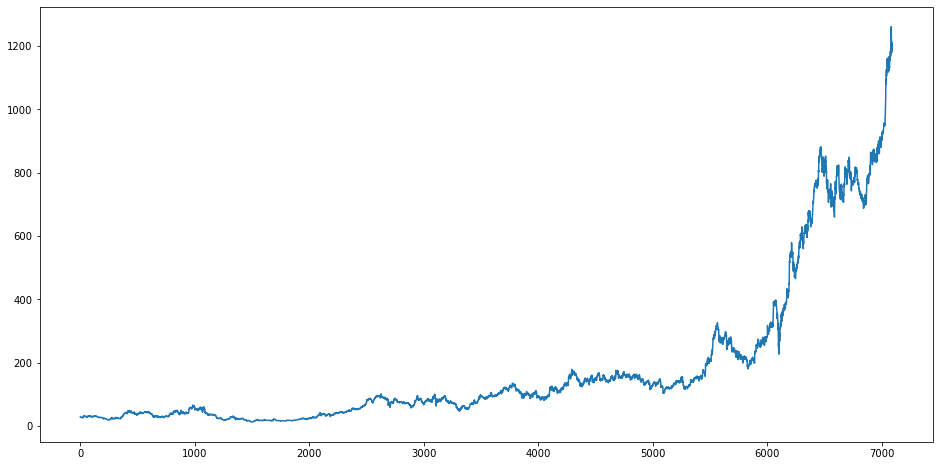

In [5]:
# ploting the graphs
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')


In [6]:
#plotting all variables
cols_plot=['Open','High','Low','Close','Adj Close']
colors = ['blue', 'green', 'red', 'purple', 'orange']
dpi = 600
fig,axes=plt.subplots(nrows=len(cols_plot),figsize=(16,7*len(cols_plot)), dpi=dpi)
for i, col in enumerate(cols_plot):
    df[col].plot(ax=axes[i], alpha=1, color=colors[i], label=col, fontsize=16)
    axes[i].set_ylabel(col + ' Variation', fontsize=18)
    axes[i].set_xlabel('Date', fontsize=18)
    axes[i].grid(True)
    axes[i].legend(fontsize=14)
fig.suptitle('Stock Price Variations', fontsize=26)
plt.tight_layout()
plt.show()


In [7]:
# changing the index to Date
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df["Date"]


In [8]:
# data sorting 
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
new_dataset = data[['Date', 'Close']].copy()
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values


In [9]:
# DATA SPLIT INTO TEST AND TRAIN
train_split = 0.8
valid_split = 0.1
total_sample = final_dataset.shape[0]
train_size = int(train_split * total_sample)
valid_size = int(valid_split * train_size)

train_data = final_dataset[0:train_size,:]
test_data = final_dataset[train_size-valid_size:train_size, :]
valid_data = final_dataset[train_size:, :]


 DATA SCALING

In [10]:
# defining scaling variables and elements
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_valid_data = scaler.transform(test_data)
scaled_test_data = scaler.transform(valid_data)


 Creating NP-Arrys for LSTM Model

In [11]:
#defining window size
window_size = 60

In [12]:
x_train_data,y_train_data=[],[]

for i in range(window_size,len(scaled_train_data)):
    x_train_data.append(scaled_train_data[i-window_size:i,0])
    y_train_data.append(scaled_train_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


In [13]:
x_valid_data, y_valid_data = [], []

for i in range(window_size, len(scaled_valid_data)):
    x_valid_data.append(scaled_valid_data[i - window_size:i, 0])
    y_valid_data.append(scaled_valid_data[i, 0])

x_valid_data, y_valid_data = np.array(x_valid_data), np.array(y_valid_data)
x_valid_data = np.reshape(x_valid_data, (x_valid_data.shape[0], x_valid_data.shape[1], 1))


In [14]:
x_test_data, y_test_data = [], []

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-window_size:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


for i in range(window_size, inputs_data.shape[0]):
    x_test_data.append(inputs_data[i - window_size:i, 0])
    y_test_data.append(inputs_data[i, 0])

x_test_data, y_test_data = np.array(x_test_data), np.array(y_test_data)
x_test_data = np.reshape(x_test_data, (x_test_data.shape[0], x_test_data.shape[1], 1))


 LSTM MODEL BUILDING

In [15]:
# MODEL STRUCTURE for Best Acccuracy
# unit = 50
# patience = 20
# epoch = 50
# batchsize = 64

unit = 50
patience = 20
epoch = 10
batchsize = 64

lstm_model=Sequential()
lstm_model.add(LSTM(units=unit,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=unit))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))


In [16]:
# model compilation
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)
lstm_model.fit(x_train_data,y_train_data,epochs=epoch,batch_size=batchsize, validation_data=(x_valid_data, y_valid_data), callbacks=[early_stop], verbose='verbose=2')

# saving the outcome in .h5 file
lstm_model.save("data/saved_lstm_model.h5")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


 PREDICTIONS BY LSTM MODEL

In [17]:
# predicting closing prices
timestpp = timestmp()
closing_price=lstm_model.predict(x_test_data)
closing_price=scaler.inverse_transform(closing_price)



45/45 [==============================] - 1s 11ms/step


In [18]:
# saving the predictions to csv
train_data=new_dataset[:train_size-valid_size]
test_data=new_dataset[train_size-valid_size:train_size]
valid_data=new_dataset[train_size:]
valid_data['Predictions'] = closing_price

#valid_data.to_csv(f"data/lstm_predictions_{timestpp}.csv")
valid_data.to_csv("data/lstm_predections.csv")


C:\Users\soura\AppData\Local\Temp\ipykernel_26212\1335008545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = closing_price


 Model Summary

In [19]:
#model Summary
test_loss = lstm_model.evaluate(x_test_data, y_test_data)
print("Test Loss:", test_loss)
lstm_model.summary()

# REGREESION METRICS FOR MODEL
mae = mean_absolute_error(valid_data["Close"], valid_data["Predictions"])
print("mean_absolute_error",mae)

mse = mean_squared_error(valid_data["Close"], valid_data["Predictions"])
print("mean_squared_error",mse)

rmse = np.sqrt(mean_squared_error(valid_data["Close"], valid_data["Predictions"]))
print("root_mean_squared_error",rmse)

r2 = r2_score(valid_data["Close"], valid_data["Predictions"])
print("r-squared_score",r2)


45/45 [==============================] - 0s 11ms/step - loss: 0.1305
Test Loss: 0.1304905116558075
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
___________________

# GRAPH PLOTING

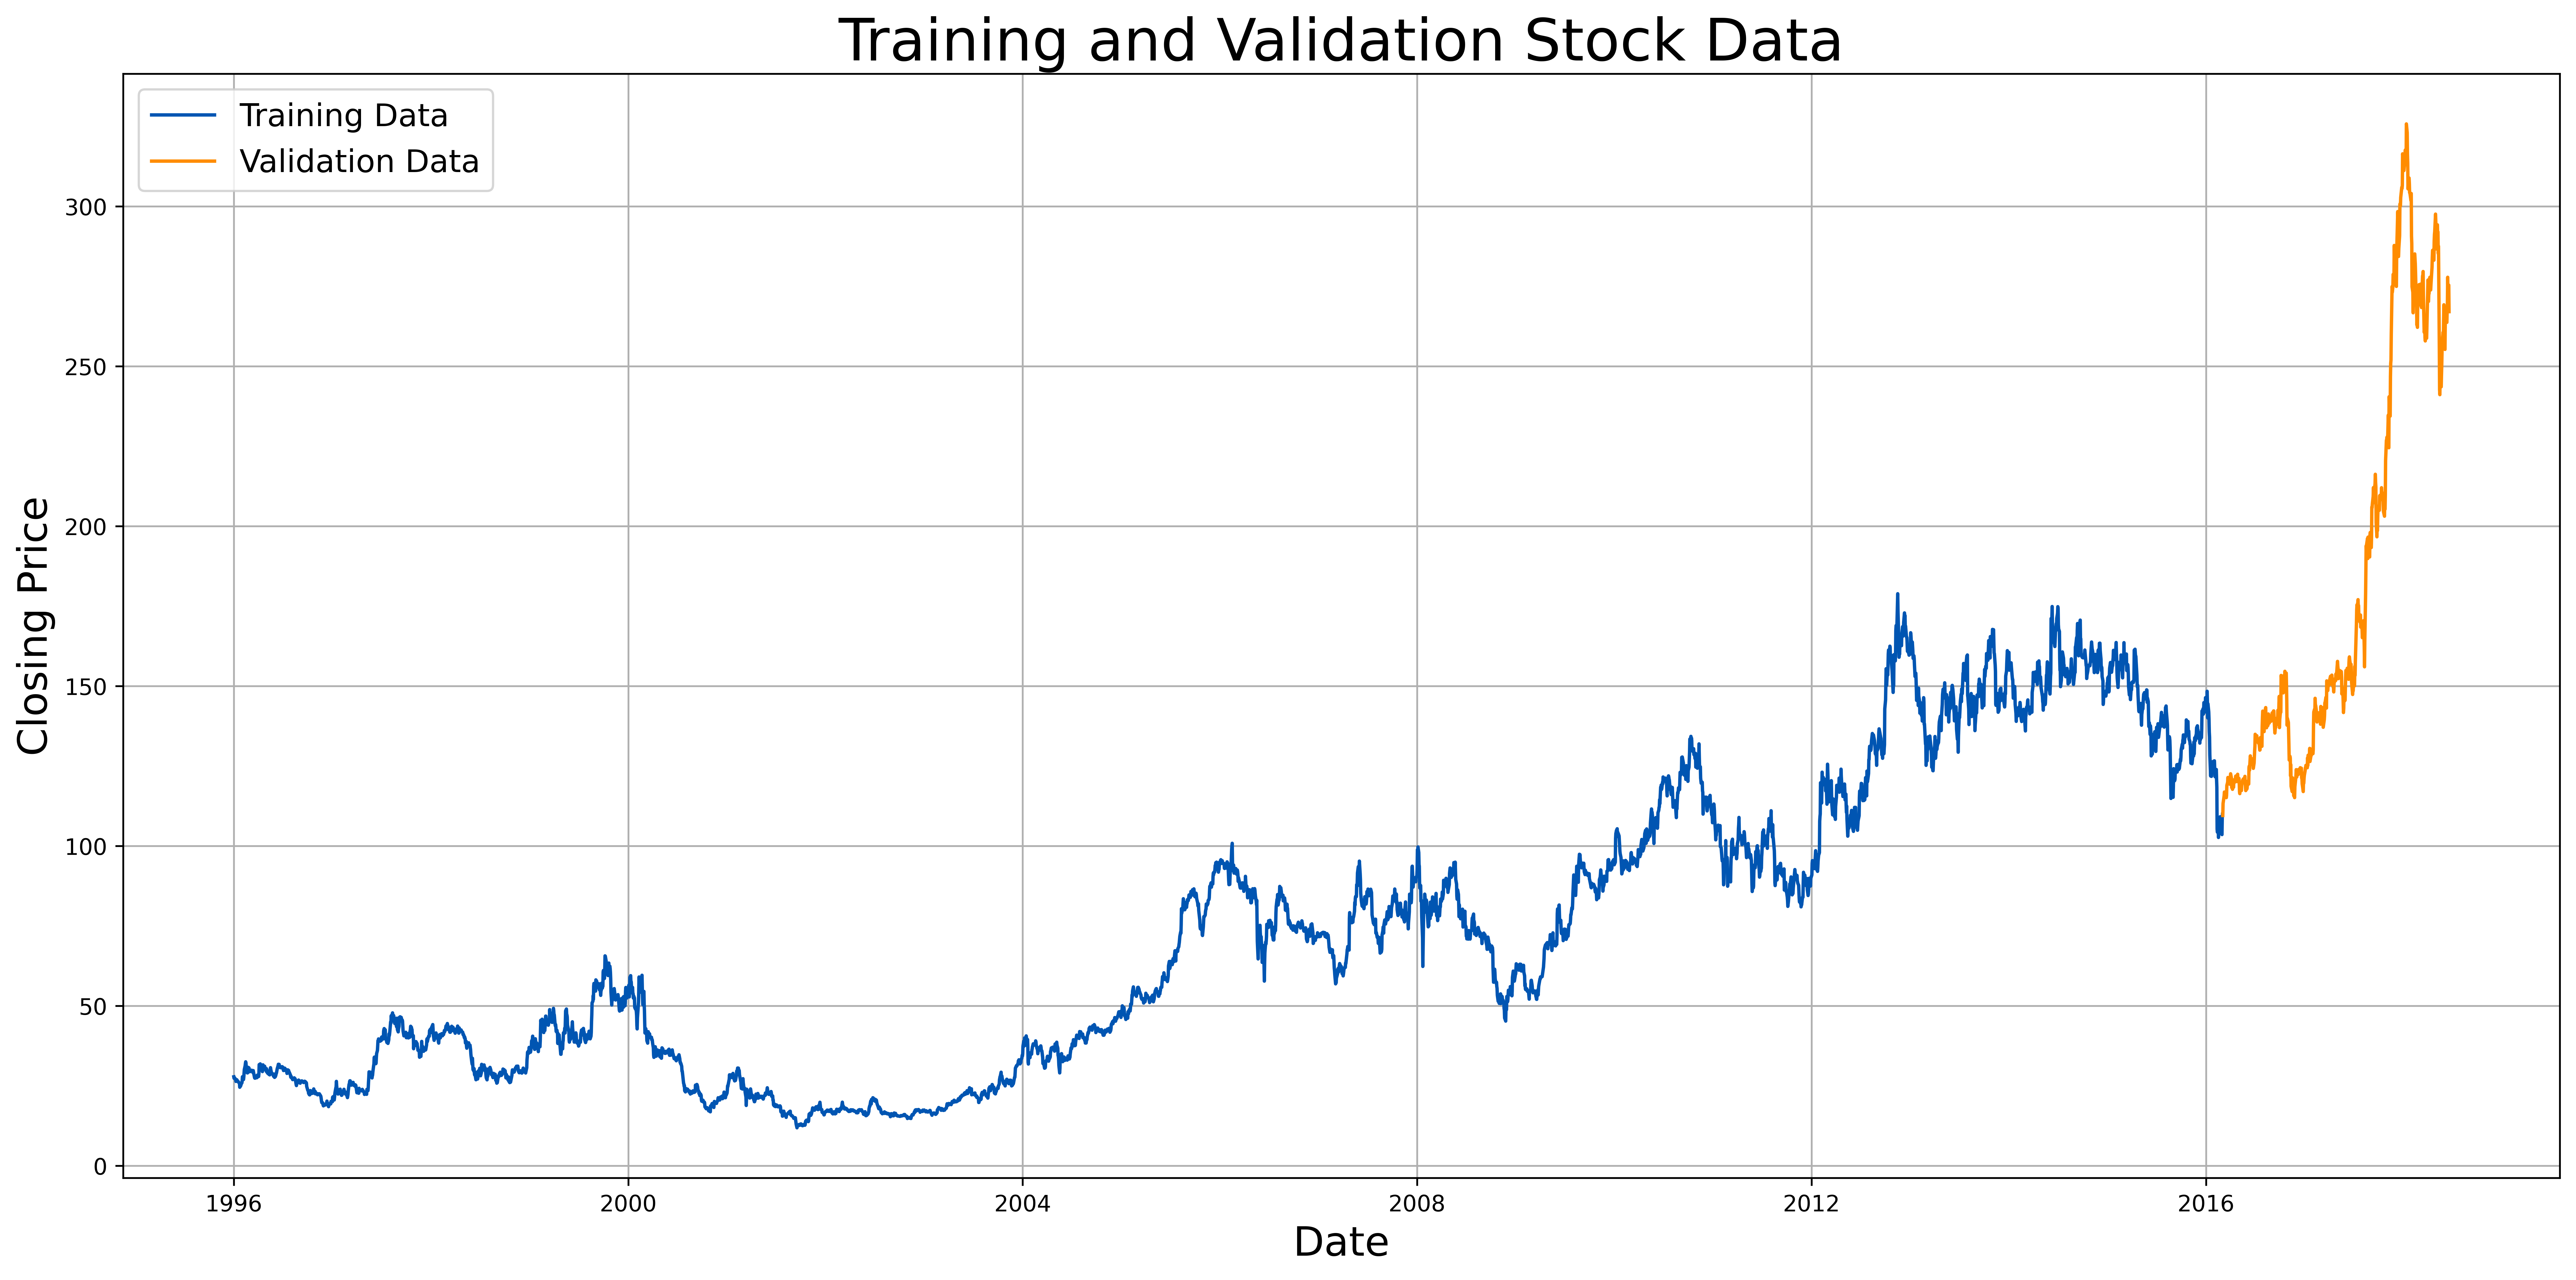

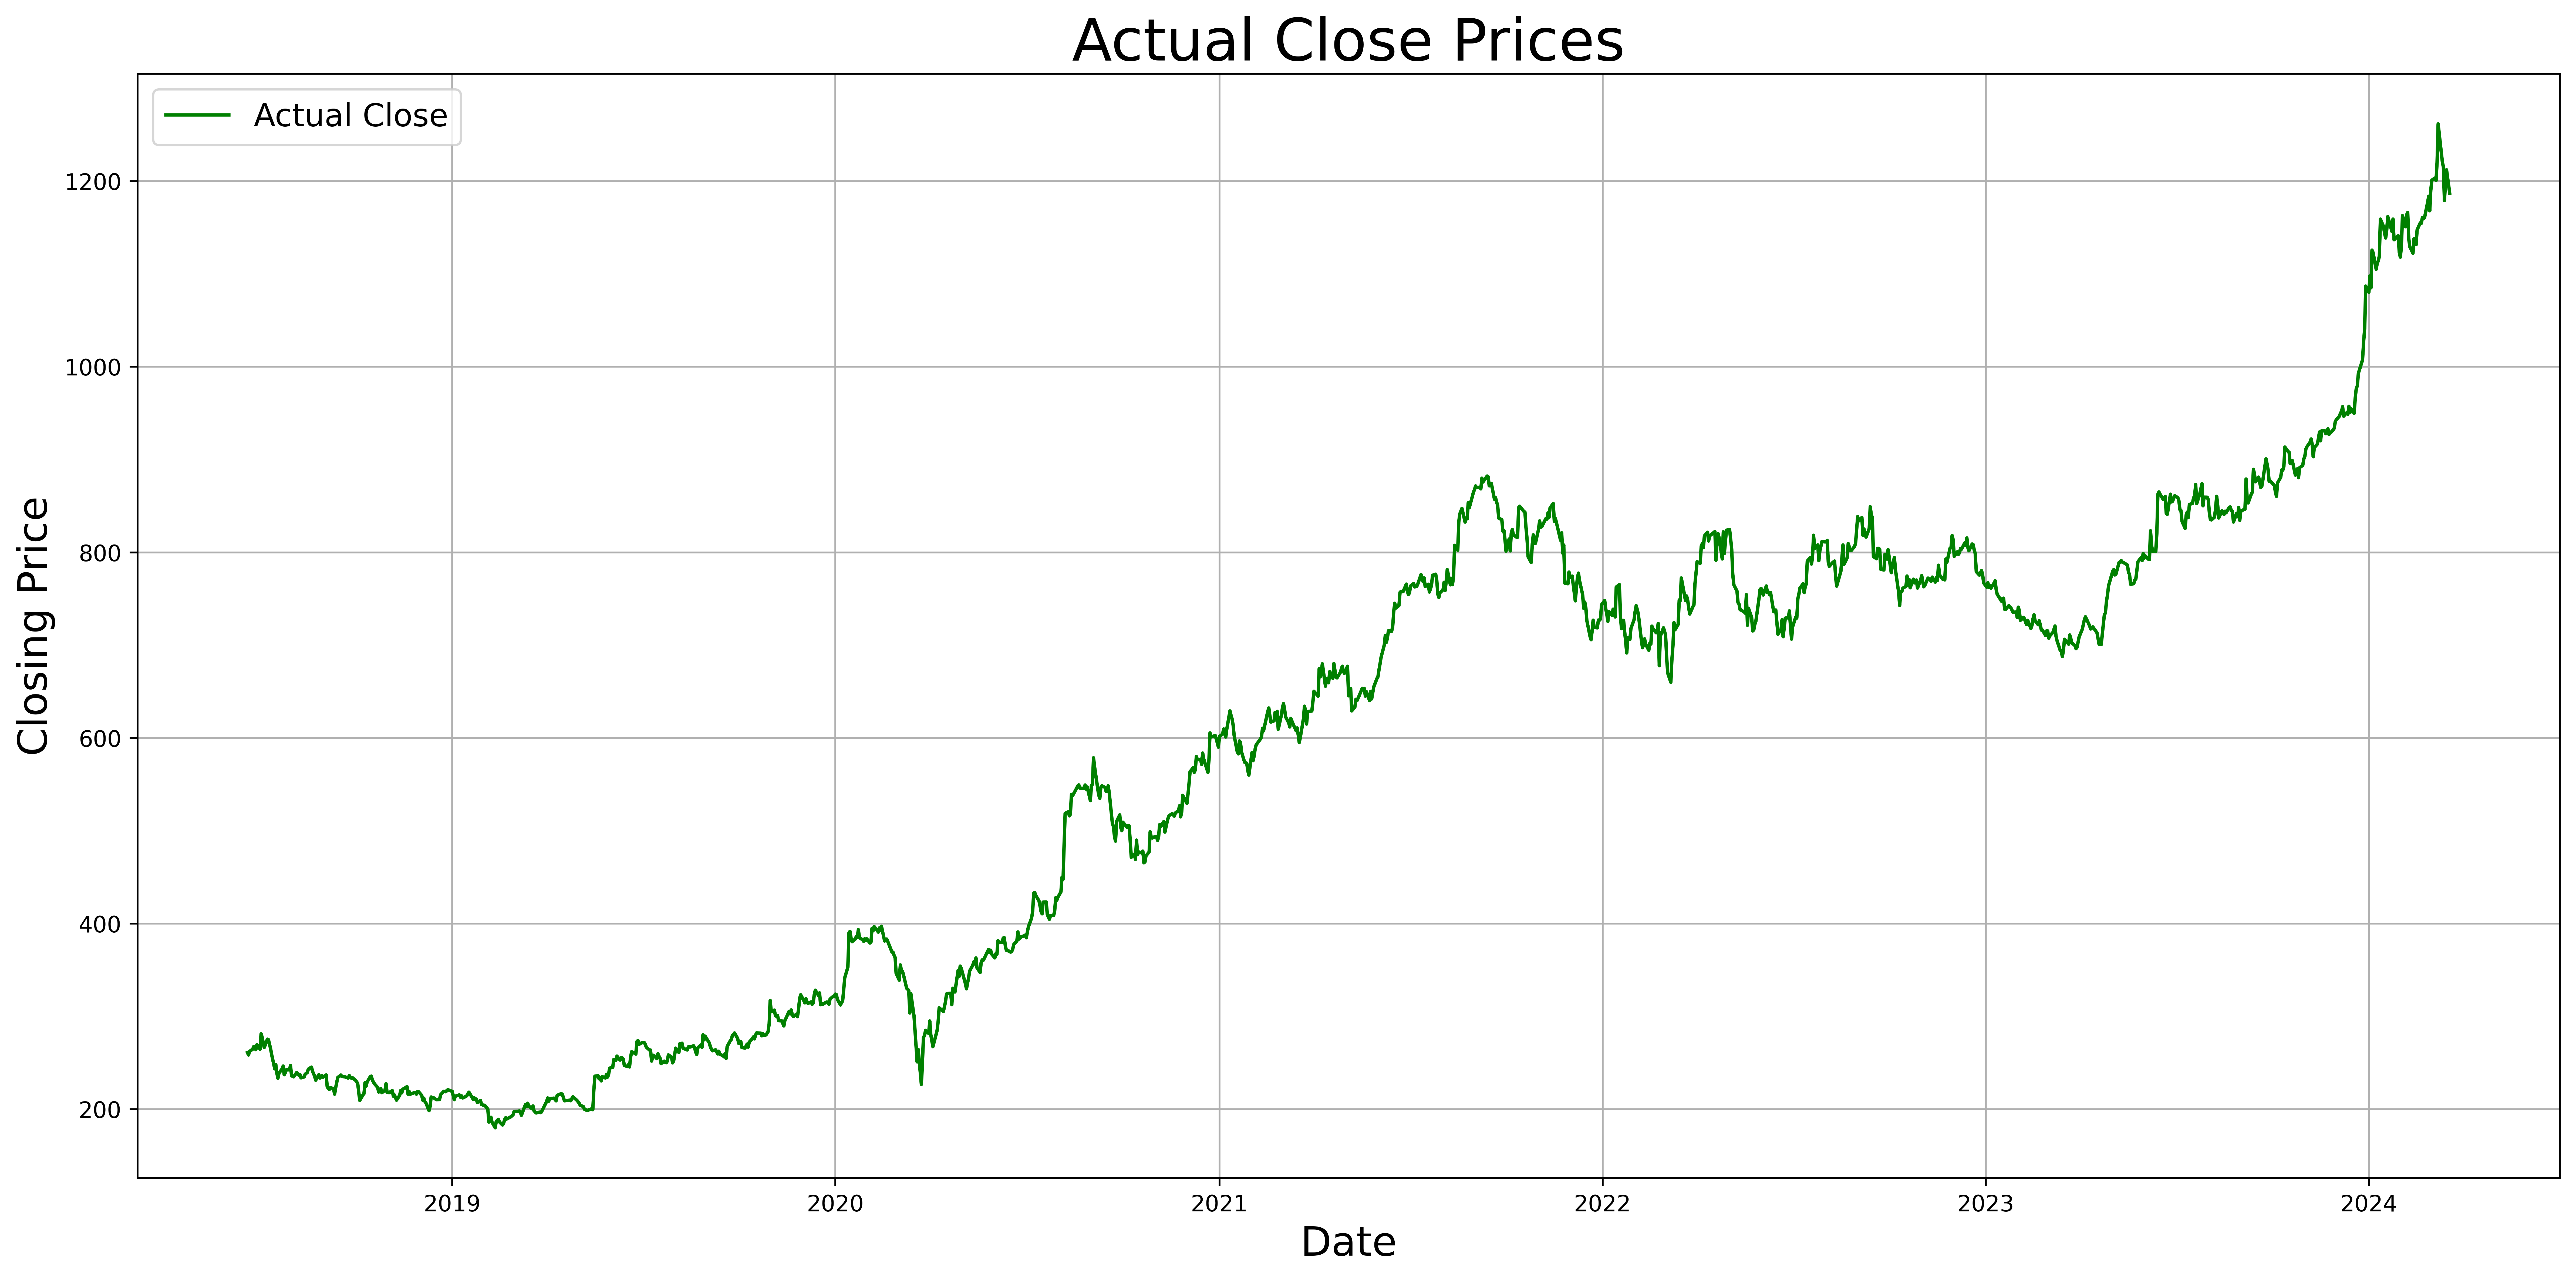

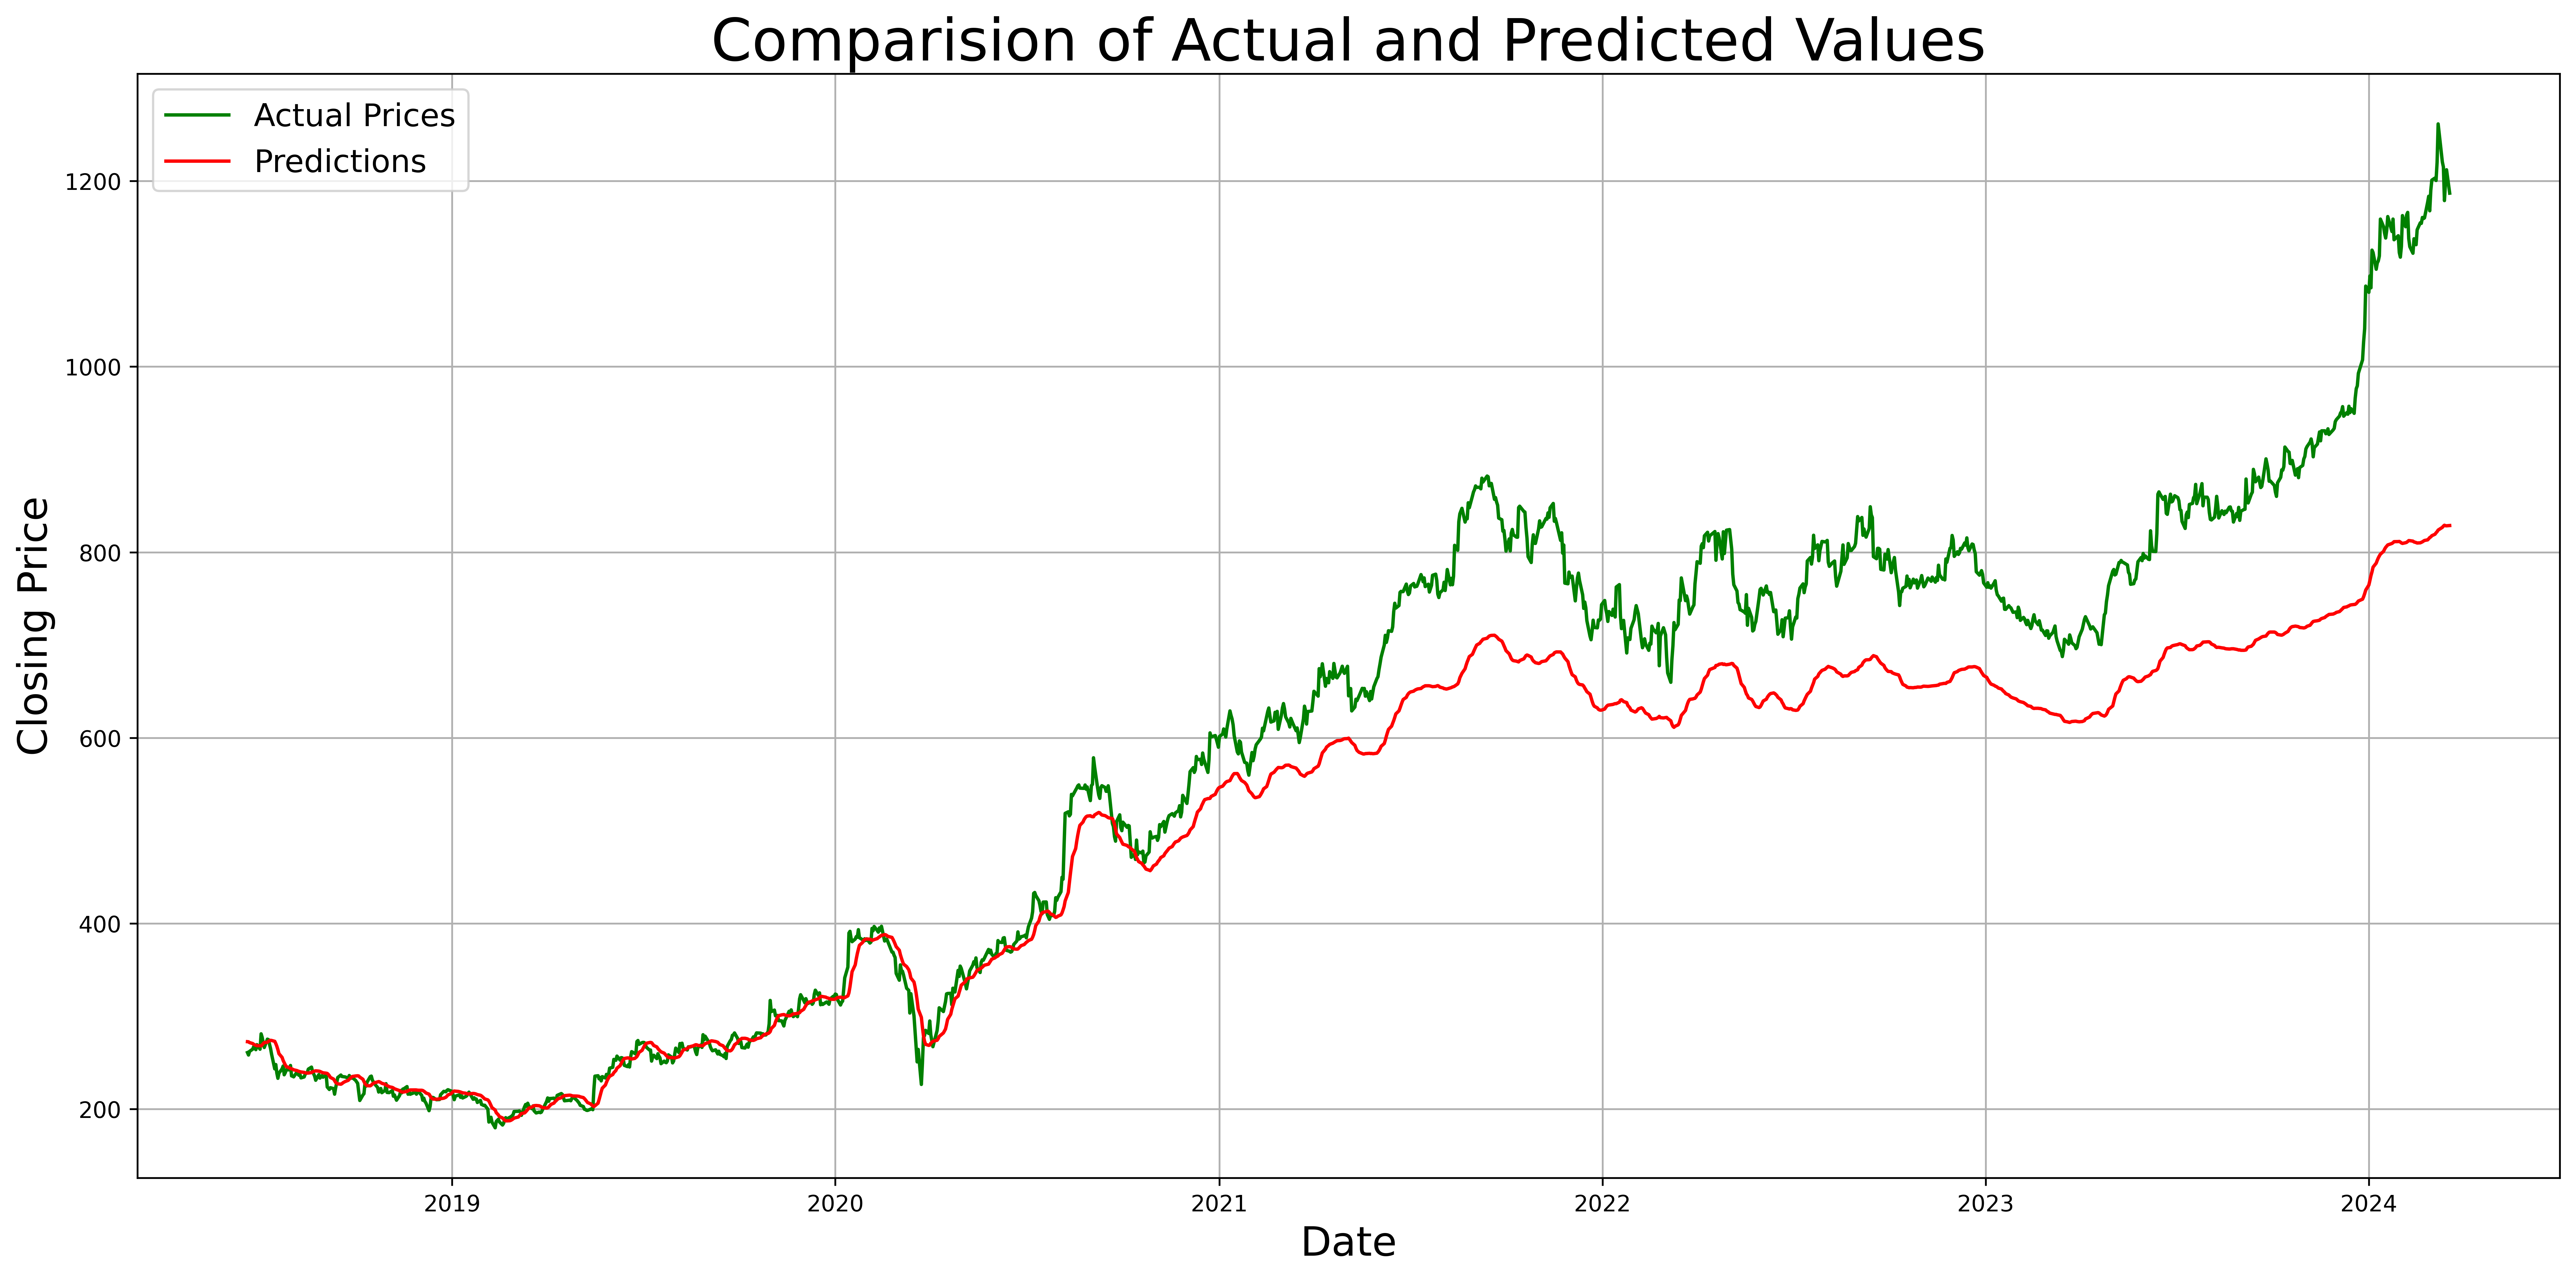

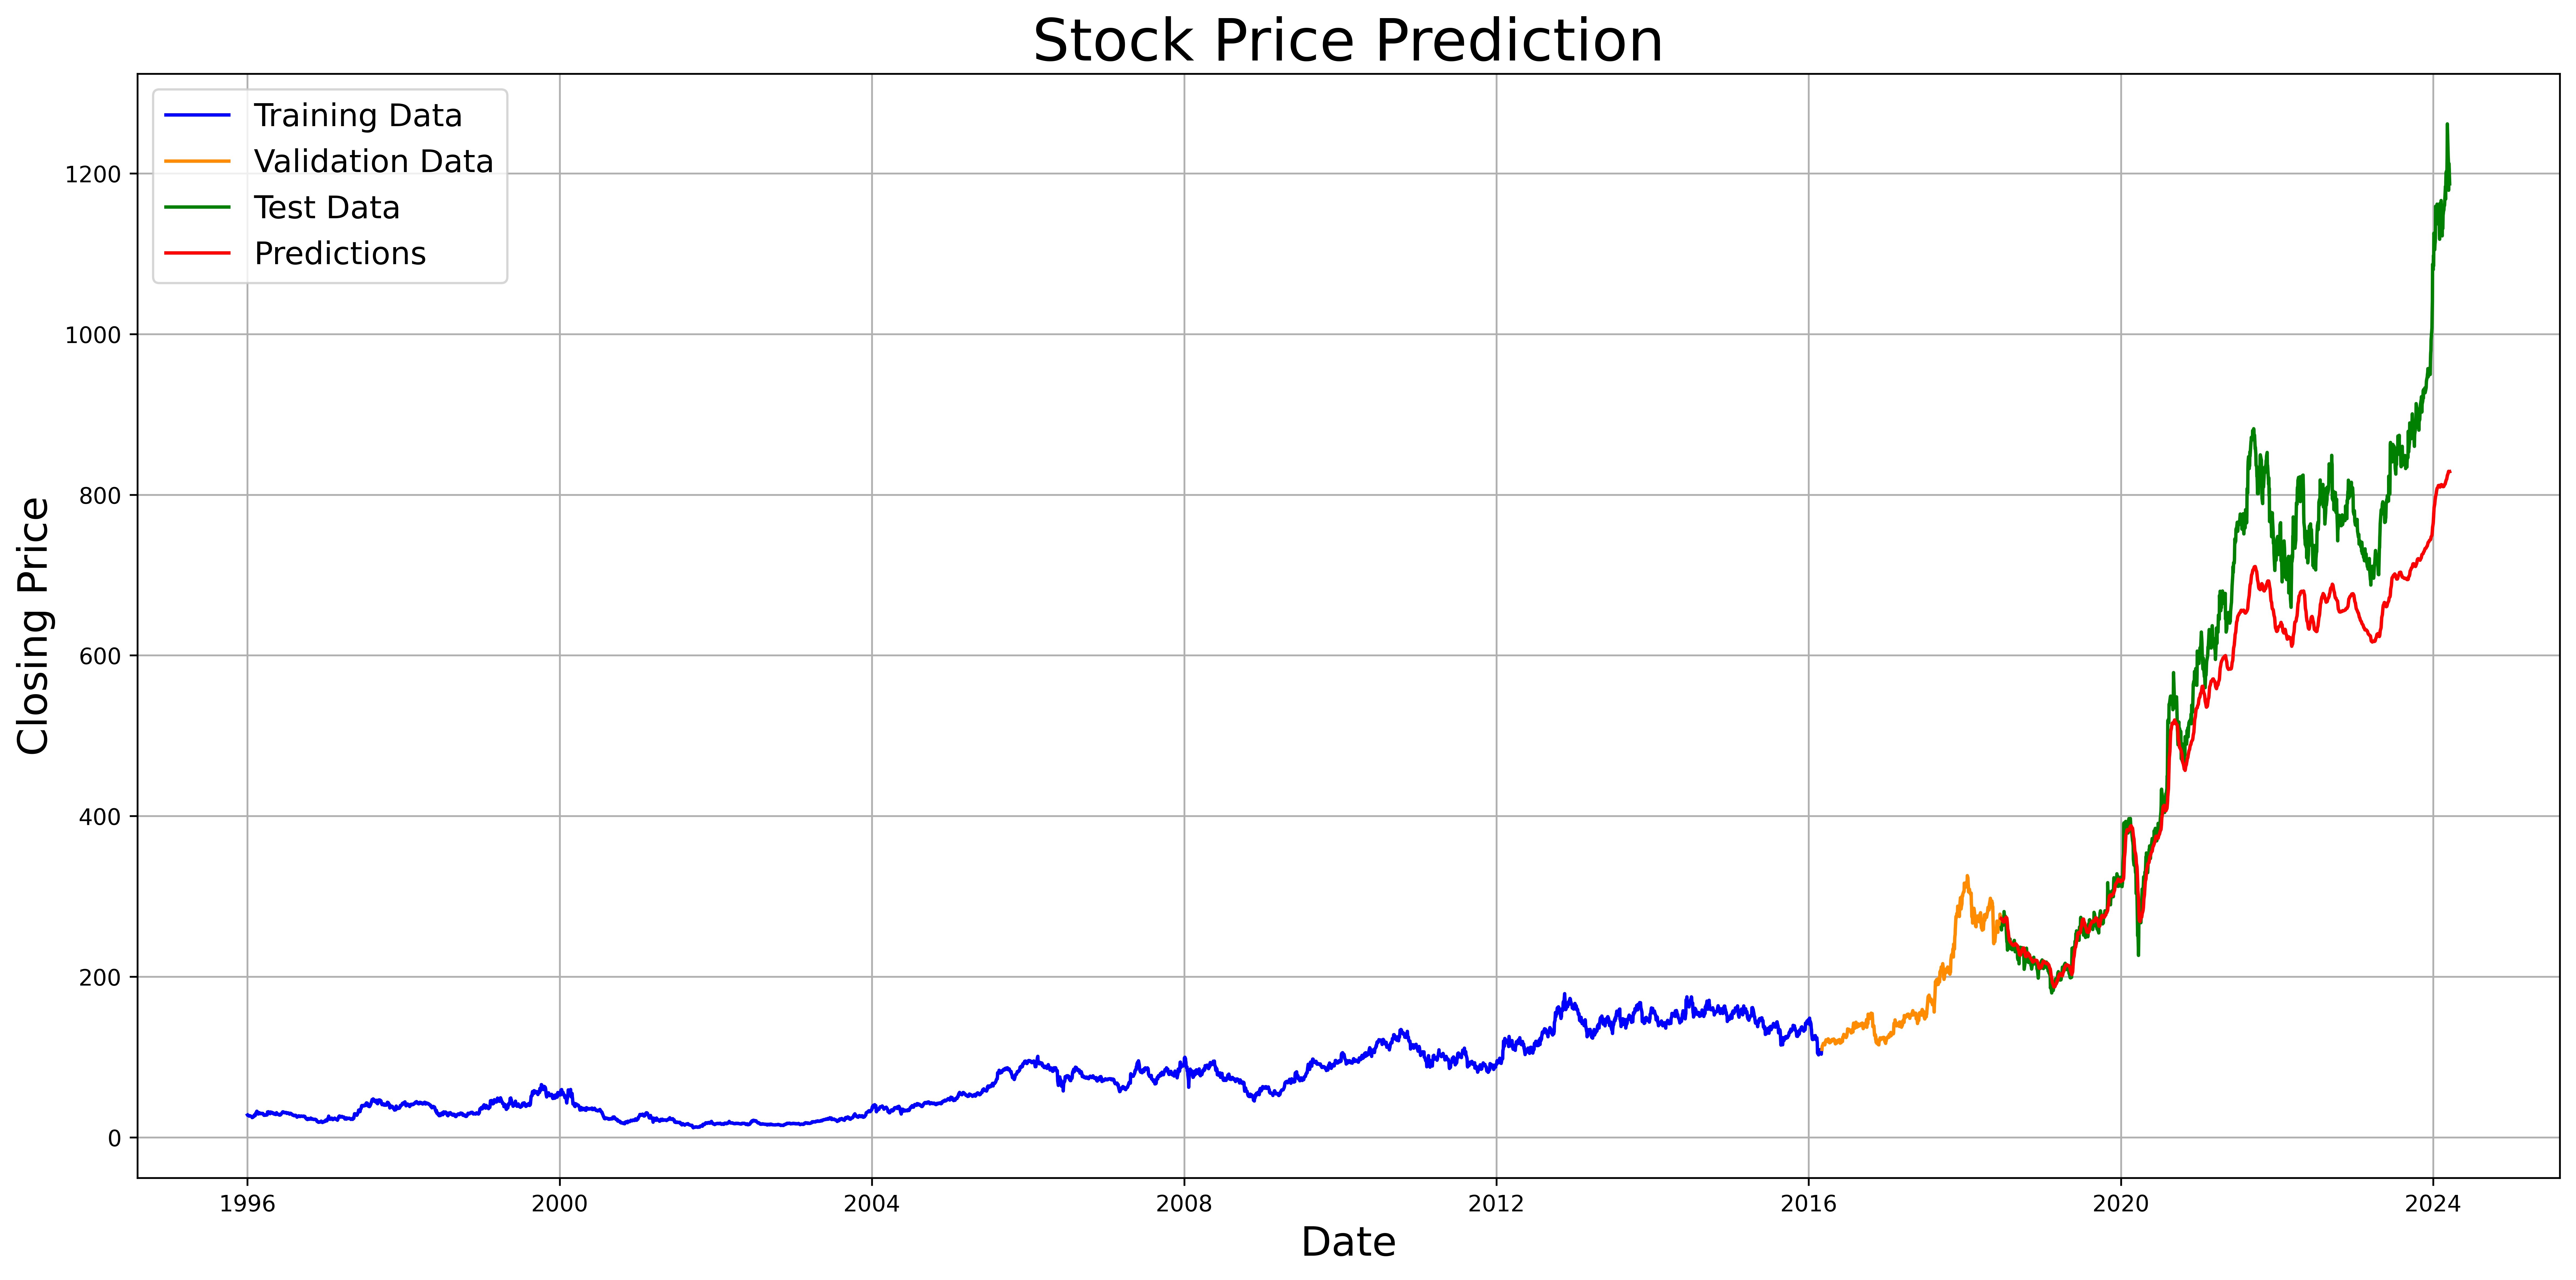

In [20]:
# ploting the outputs
dpi = 600


plt.figure(figsize=(16,8),dpi=dpi)

plt.plot(train_data.index, train_data["Close"],
         label="Training Data",
         color="#0055b2")
plt.plot(test_data.index, test_data['Close'],
         label='Validation Data',
         color='DarkOrange')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.title('Training and Validation Stock Data', fontsize=26)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8),dpi=dpi)

plt.plot(valid_data.index, valid_data["Close"],
         label="Actual Close",
         color="green")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.title('Actual Close Prices', fontsize=26)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

dpi = 600

plt.figure(figsize=(16,8),dpi=dpi)
plt.plot(valid_data.index, valid_data['Close'],
         label="Actual Prices",
         color="green")
plt.plot(valid_data.index, valid_data["Predictions"],
         label="Predictions",
         color="red")
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.title('Comparision of Actual and Predicted Values',fontsize=26)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plot_title = "Comparision of Actual and Predicted Values"
#saved = save_plot(plt.gcf(),plot_title,epoch,batchsize,patience,timestpp)
plt.show()

# if saved:
#     print(f"Plot saved_{plot_title}")
# else:
#     print("Error : Plot not saved")


plt.figure(figsize=(16,8),dpi=dpi)
plt.plot(train_data.index, train_data["Close"],
         label="Training Data",
         color="Blue")
plt.plot(test_data.index, test_data['Close'],
         label='Validation Data',
         color='DarkOrange')
plt.plot(valid_data.index, valid_data['Close'],
         label="Test Data",
         color="Green")
plt.plot(valid_data.index, valid_data["Predictions"],
         label="Predictions",
         color="red")
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.title('Stock Price Prediction',fontsize=26)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plot_title = "Stock Price Prediction"
#saved = save_plot(plt.gcf(),plot_title,epoch,batchsize,patience,timestpp)
plt.show()

# if saved:
#     print(f"Plot saved_{plot_title}")
# else:
#     print("Error : Plot not saved")


 Updating Excel File (model_perfornmace.xlsx)

In [21]:
# Define the Excel file path
excel_file = ('data/model_performance.xlsx')

# Check if the Excel file exists, and if not, create it with the initial data
if not os.path.exists(excel_file):
    df_excel = pd.DataFrame()
    
    df_excel.to_excel(excel_file, index=False)
    print(f"Excel file '{excel_file}' created successfully with initial data.")

# Function to append new records with the same attributes but new values
def append_variables_to_excel(timestp ,data_split, units, patience, epochs, batchsize, mae, mse, rmse, test_loss, r2):
    try:
        # Read the existing data from the Excel file
        existing_data = pd.read_excel(excel_file)

        # Create a new DataFrame with the new values in a horizontal format
        new_record = pd.DataFrame({
            'Attribute': ['Timestamp','Data Split', 'Units', 'Patience', 'Epochs', 'Batch Size', 'MAE', 'MSE', 'RMSE', 'Test Loss', 'R2'],
            'Value': [timestp, data_split, units, patience, epochs, batchsize, mae, mse, rmse, test_loss, r2]
        })

        # Transpose the new record so that attributes become column headers and values are placed in a new row
        new_record = new_record.transpose()

        # Rename the columns to use the first row as headers
        new_record.columns = new_record.iloc[0]

        # Drop the first row
        new_record = new_record[1:]

        # Concatenate the new record to the existing data (vertically, in a new row)
        updated_data = pd.concat([existing_data, new_record], axis=0, ignore_index=True)

        # Save the updated data back to the Excel file
        updated_data.to_excel(excel_file, index=False)
        print(f"New record appended to '{excel_file}' successfully.")
    except Exception as e:
        print(f"Error: {e}")


append_variables_to_excel(timestpp,train_split, unit, patience, epoch, batchsize,  mae, mse, rmse, test_loss, r2)


New record appended to 'data/model_performance.xlsx' successfully.


In [22]:

# # predicting value ahead of test data points   
# last_data_point = x_test_data[-1]
# new_data_point = inputs_data[-1]

# ex_x_test_data = np.append(last_data_point, new_data_point)

# ex_x_test_data = ex_x_test_data.reshape(1,-1,1)

# predict_val = lstm_model.predict(ex_x_test_data)
# predict_val=scaler.inverse_transform(predict_val)


# x_test_data = x_test_data[1:]
# x_test_data = np.append(x_test_data, predict_val)


In [27]:
from nbconvert import PythonExporter

# Create a PythonExporter instance
exporter = PythonExporter()

# Extract the Python code from the current notebook
python_code, _ = exporter.from_filename('stock_pred.ipynb')

# Save the extracted Python code to a .py file
with open('stock_pred.py', 'w') as f:
    f.write(python_code)